[目录](./table_of_contents.ipynb)

# 卡尔曼滤波器的数学

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

如果你已经读到这里，我希望你会认为卡尔曼滤波器的可怕名声有点不应该。当然，我已经把一些方程排除了，但我希望实现对你来说相当简单。其基本概念非常简单——取两个测量值，或者一个测量值和一个预测值，然后选择介于两者之间的输出值。如果你相信测量值越高，你的猜测值就越接近测量值，如果你相信预测值越准确，你的猜测值就越接近它。这不是火箭科学(开个小玩笑——正是这个数学让阿波罗登上月球并返回!)

说实话，我一直在仔细选择我的问题。对于任意问题，卡尔曼滤波器矩阵的设计是极其困难的。不过，我并没有“太狡猾”。像牛顿运动方程这样的方程，对于卡尔曼滤波应用来说，可以简单地计算出来，它们构成了我们想要解决的大部分问题。

我用代码和推理来说明这些概念，而不是数学。但有些话题确实需要比我目前使用的更多的数学知识。这一章介绍了你在接下来的书中所需要的数学知识。

## 动态系统建模

一个“动态系统”是一个物理系统，它的状态(位置、温度等)会随着时间而变化。微积分是改变数值的数学，所以我们用微分方程来建模动态系统。有些系统不能用微分方程来建模，但我们在这本书中不会遇到。

建立动态系统的模型恰当地成为一些大学课程的主题。在某种程度上，没有什么可以替代几个学期的常微分方程和偏微分方程，然后是控制系统理论的研究生课程。如果你是一个业余爱好者，或者在工作中试图解决一个非常具体的过滤问题，你可能没有时间和/或意愿投入一年或更多的时间去学习。

幸运的是，我可以提供足够的理论，让我们能够为许多不同的卡尔曼滤波器创建系统方程。我的目标是让您能够阅读出版物并充分理解它，从而实现算法。背景数学很深奥，但在实践中我们最终使用了一些简单的技巧。

这是这本书中最长的纯数学部分。你需要掌握本节的所有内容，才能理解扩展卡尔曼滤波器(EKF)，这是最常见的非线性滤波器。我介绍了更多不需要这么多数学运算的现代滤波器。你可以选择现在略读，如果你决定学习EKF，再回到这里。

我们需要从理解卡尔曼滤波器使用的基本方程和假设开始。我们试图模拟真实世界的现象，那么我们需要考虑什么呢?

每个物理系统都有一个进程。例如，一辆以一定速度行驶的汽车在一定的时间内行驶了这么远，它的速度随加速度而变化。我们用我们在高中学过的牛顿方程来描述这种行为。

$$
\begin{aligned}
v&=at\\
x &= \frac{1}{2}at^2 + v_0t + x_0
\end{aligned}
$$

一旦我们学习了微积分，我们就会看到这种形式:

$$ \mathbf v = \frac{d \mathbf x}{d t}, 
\quad \mathbf a = \frac{d \mathbf v}{d t} = \frac{d^2 \mathbf x}{d t^2}
$$

一个典型的汽车跟踪问题需要你在给定恒定速度或加速度的情况下计算行驶的距离，就像我们在前几章中做的那样。但是，我们当然知道这并不是正在发生的全部。没有一辆车能在一条完美的道路上行驶。有颠簸，风的阻力，和上升和降低速度的小山。悬架是一个机械系统，有摩擦和不完善的弹簧。

完美的系统建模是不可能的，除非有最琐碎的问题。我们被迫做一个简化。在任何时候$t$，我们说真实的状态(例如我们的车的位置)是来自不完美模型的预测值加上一些未知的*过程噪声*:

$$
x(t) = x_{pred}(t) + noise(t)
$$

这并不是说$noise(t)$是一个可以解析推导的函数。它仅仅是一个事实的陈述——我们总是可以将真实值描述为预测值加上过程噪声。“噪音”并不意味着随机事件。如果我们在大气中追踪一个被扔出的球，并且我们的模型假设球在真空中，那么空气阻力的影响就是在这种情况下的过程噪声。

在下一节中，我们将学习将一组高阶微分方程转化为一组一阶微分方程的技巧。转换后无噪声系统的模型为:

$$ \dot{\mathbf x} = \mathbf{Ax}$$

$\mathbf A$被称为*系统动力学矩阵*，因为它描述了系统的动力学。现在我们需要对噪声进行建模。我们将其命名为$\mathbf w$，并将其添加到方程中。

$$ \dot{\mathbf x} = \mathbf{Ax} + \mathbf w$$

$\mathbf w$可能会让你觉得这个名字不太合适，但你很快就会看到卡尔曼滤波器假设有*白*噪声。

最后，我们需要考虑系统中的任何输入。我们假设输入$\mathbf u$，并且存在一个线性模型来定义输入如何改变系统。例如，按下汽车的加速器会使汽车加速，重力会使球体下落。两者都是控制输入。我们需要一个矩阵$\mathbf B$来将$u$转换成对系统的影响。我们把它加到方程中:

$$ \dot{\mathbf x} = \mathbf{Ax} + \mathbf{Bu} + \mathbf{w}$$

就是这样。这是卡尔曼博士着手解决的一个方程，他发现了一个最优估计如果我们假设$\mathbf w$的某些性质。

## 动态系统的状态空间表示

我们已经推导出了方程

$$ \dot{\mathbf x} = \mathbf{Ax}+ \mathbf{Bu} + \mathbf{w}$$

然而，我们感兴趣的不是$\mathbf x$的导数，而是$\mathbf x$本身。暂时忽略噪声，我们想要一个方程，它可以用$t_{k-1}$的$\mathbf x$来递归地计算$t_k$的$\mathbf x$的值:

$$\mathbf x(t_k) = \mathbf F(\Delta t)\mathbf x(t_{k-1}) + \mathbf B(t_k)\mathbf u (t_k)$$

按照惯例，我们可以将$\mathbf x(t_k)$写成$\mathbf x_k$，意思是$t$的k$^{th}$值处$\mathbf x$的值。

$$\mathbf x_k = \mathbf{Fx}_{k-1} + \mathbf B_k\mathbf u_k$$

$\mathbf F$是我们熟悉的*状态转移矩阵*，因为它能够在离散时间步之间转换状态值而得名。它非常类似于系统动力学矩阵$\mathbf A$。区别在于$\mathbf A$模型是一组线性微分方程，并且是连续的。$\mathbf F$是离散的，它表示在一个离散时间步长$\Delta t$上将$\mathbf x_{k-1}$转换为$\mathbf x_k$的一组线性方程(不是微分方程)。

找到这个矩阵通常是相当困难的。方程$\dot x = v$是可能最简单的微分方程，我们简单地积分它为:

$$ \int\limits_{x_{k-1}}^{x_k}  \mathrm{d}x = \int\limits_{0}^{\Delta t} v\, \mathrm{d}t $$
$$x_k-x_0 = v \Delta t$$
$$x_k = v \Delta t + x_0$$
 
这个方程是*递归的*:我们根据$t-1$的值计算$t$时$x$的值。这种递归形式使我们能够以卡尔曼滤波器所要求的形式表示系统(过程模型):

$$\begin{aligned}
\mathbf x_k &= \mathbf{Fx}_{k-1}  \\
&= \begin{bmatrix} 1 & \Delta t \\ 0 & 1\end{bmatrix}
\begin{bmatrix}x_{k-1} \\ \dot x_{k-1}\end{bmatrix}
\end{aligned}$$
 
这样做是因为$\dot x = v$是最简单的微分方程。在物理系统中，几乎所有其他的都导致了更复杂的微分方程，而这些微分方程不屈服于这种方法。

“状态空间”方法在阿波罗任务前后开始流行，这在很大程度上归功于卡尔曼博士的工作。这个想法很简单。用一组$n^{th}$阶微分方程建立系统模型。把它们转换成一阶微分方程的等价集合。将它们转换为上一节中使用的向量矩阵形式:$\dot{\mathbf x} = \mathbf{Ax} + \mathbf{Bu}$。在这种形式下，我们使用以下几种技术将这些线性微分方程转化为递归方程:

$$ \mathbf x_k = \mathbf{Fx}_{k-1} + \mathbf B_k\mathbf u_k$$

有些书称状态转移矩阵为基本矩阵。许多人使用$\mathbf \Phi$而不是$\mathbf F$。大量基于控制理论的资源倾向于使用这些形式。

这些被称为*状态空间*方法，因为我们用系统状态来表示微分方程的解。

### 由高阶方程形成一阶方程

许多物理系统模型需要二阶或更高阶微分方程，控制输入为$u$:

$$a_n \frac{d^ny}{dt^n} + a_{n-1} \frac{d^{n-1}y}{dt^{n-1}} +  \dots + a_2 \frac{d^2y}{dt^2} + a_1 \frac{dy}{dt} + a_0 = u$$
. 
状态空间方法需要一阶方程。任何高阶方程组都可以被简化为一阶，通过定义额外的变量，然后求解。

举个例子。给定系统$\ddot{x} - 6\dot x + 9x = u$，求等价的一阶方程。为了清晰起见，我用点符号表示对时间的导数。

第一步是把最高阶项分离到方程的一边。

$$\ddot{x} = 6\dot x - 9x + u$$

我们定义了两个新变量:

$$\begin{aligned} x_1(u) &= x \\
x_2(u) &= \dot x
\end{aligned}$$
 
现在我们把这些代入原方程，然后解。这个解由这些新变量得到一组一阶方程。为了便于标注，通常省略$(u)$。

我们知道 $\dot x_1 = x_2$ 和 $\dot x_2 = \ddot{x}$. 因此

$$\begin{aligned}
\dot x_2 &= \ddot{x} \\
         &= 6\dot x - 9x + t\\
         &= 6x_2-9x_1 + t
\end{aligned}$$

因此我们的一阶方程组是

$$\begin{aligned}\dot x_1 &= x_2 \\
\dot x_2 &= 6x_2-9x_1 + t\end{aligned}$$
 
如果你多练习一下，你就会熟练了。分离出最高项，定义一个新变量及其导数，然后代入。

### 状态空间形式的一阶微分方程

将上一节中新定义的变量替换为:

$$\frac{dx_1}{dt} = x_2,\,  
\frac{dx_2}{dt} = x_3, \, ..., \, 
\frac{dx_{n-1}}{dt} = x_n$$

一阶方程得到:

$$\frac{dx_n}{dt} = \frac{1}{a_n}\sum\limits_{i=0}^{n-1}a_ix_{i+1} + \frac{1}{a_n}u
$$

使用向量矩阵表示法，我们有:

$$\begin{bmatrix}\frac{dx_1}{dt} \\ \frac{dx_2}{dt} \\ \vdots \\ \frac{dx_n}{dt}\end{bmatrix} = 
\begin{bmatrix}\dot x_1 \\ \dot x_2 \\ \vdots \\ \dot x_n\end{bmatrix}=
\begin{bmatrix}0 & 1 & 0 &\cdots & 0 \\
0 & 0 & 1 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
-\frac{a_0}{a_n} & -\frac{a_1}{a_n} & -\frac{a_2}{a_n} & \cdots & -\frac{a_{n-1}}{a_n}\end{bmatrix}
\begin{bmatrix}x_1 \\ x_2 \\ \vdots \\ x_n\end{bmatrix} + 
\begin{bmatrix}0 \\ 0 \\ \vdots \\ \frac{1}{a_n}\end{bmatrix}u$$

然后我们将其写成$\dot{\mathbf x} = \mathbf{Ax} + \mathbf{B}u$。

### 求时不变系统的基本矩阵

我们用状态空间形式表示系统方程

$$ \dot{\mathbf x} = \mathbf{Ax}$$

其中$\mathbf A$是系统动力学矩阵，并且想要找到基本矩阵* $ mathbf F$，它用这个方程在区间$\Delta t$上传播状态$ mathbf x$

$$\begin{aligned}
\mathbf x(t_k) = \mathbf F(\Delta t)\mathbf x(t_{k-1})\end{aligned}$$
 
换句话说，$\mathbf A$是一组连续微分方程，而我们需要$\mathbf F$是一组离散线性方程，计算$\mathbf A$在一个离散时间步长的变化。
 
通常省略$t_k$和$(\Delta t)$并用符号表示

$$\mathbf x_k = \mathbf {Fx}_{k-1}$$
 
一般来说，有三种常见的方法来找到这个矩阵的卡尔曼滤波器。最常用的方法是矩阵指数法。线性时不变理论，也称为LTI系统理论，是第二种技术。最后，还有数值技术。你可能知道其他的，但这三种是你在卡尔曼滤波文献和实践中最有可能遇到的。

### 矩阵指数

方程$\frac{dx}{dt} = kx$的解可由:

$$\begin{gathered}\frac{dx}{dt} = kx \\
\frac{dx}{x} = k\, dt \\
\int \frac{1}{x}\, dx = \int k\, dt \\
\log x = kt + c \\
x = e^{kt+c} \\
x = e^ce^{kt} \\
x = c_0e^{kt}\end{gathered}$$
 
用类似的数学方法，一阶方程的解

$$\dot{\mathbf x} = \mathbf{Ax} ,\, \, \, \mathbf x(0) = \mathbf x_0$$
 
其中$\mathbf A$是一个常数矩阵，是

$$\mathbf x = e^{\mathbf At}\mathbf x_0$$
 
将$F = e^{\mathbf At}$代入，可以写成

$$\mathbf x_k = \mathbf F\mathbf x_{k-1}$$

这就是我们要找的形式!我们已经把求基本矩阵的问题简化为求$e^{\mathbf At}$的值的问题。
 
$e^{\mathbf At}$被称为[矩阵指数](https://en.wikipedia.org/wiki/Matrix_exponential)。它可以用这个幂级数来计算:

$$e^{\mathbf At} = \mathbf{I} + \mathbf{A}t  + \frac{(\mathbf{A}t)^2}{2!} + \frac{(\mathbf{A}t)^3}{3!} + ... $$

这个级数是通过对$e^{\mathbf At}$进行泰勒级数展开得到的，这里我就不讲了。
  
我们用这个来求牛顿方程的解。用$v$替换$\dot x$，并假设速度恒定，我们得到线性矩阵向量形式

$$\begin{bmatrix}\dot x \\ \dot v\end{bmatrix} =\begin{bmatrix}0&1\\0&0\end{bmatrix} \begin{bmatrix}x \\ v\end{bmatrix}$$
 
这是一个一阶微分方程，因此我们可以设$\mathbf{A}=\begin{bmatrix}0&1\\0&0\end{bmatrix}$并解以下方程。我用区间$t$代替$t$来强调基本矩阵是离散的:

$$\mathbf F = e^{\mathbf A\Delta t} = \mathbf{I} + \mathbf A\Delta t  + \frac{(\mathbf A\Delta t)^2}{2!} + \frac{(\mathbf A\Delta t)^3}{3!} + ... $$
 
如果你执行乘法运算，你会发现$\mathbf{A}^2=\begin{bmatrix}0&0\\0&0\end{bmatrix}$，这意味着$\mathbf{A}$的所有高次幂也是$\mathbf{0}$。这样我们就得到了一个不含无限项的精确答案:

$$
\begin{aligned}
\mathbf F &=\mathbf{I} + \mathbf A \Delta t + \mathbf{0} \\
&= \begin{bmatrix}1&0\\0&1\end{bmatrix} + \begin{bmatrix}0&1\\0&0\end{bmatrix}\Delta t\\
&= \begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}
\end{aligned}$$
 
我们把它代入$\mathbf x_k= \mathbf{Fx}_{k-1}$中得到

$$
\begin{aligned}
x_k &=\begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}x_{k-1}
\end{aligned}$$
 
在**多元卡尔曼滤波器**一章中，您将认识到这是我们通过分析推导出的常数速度卡尔曼滤波器矩阵。
  
SciPy的linalg模块包括一个计算矩阵指数的函数`expm()`。它没有使用泰勒级数法，而是使用[Padé近似](https://en.wikipedia.org/wiki/Pad%C3%A9_approximant)。计算矩阵指数的方法有很多(至少19种)，但都存在数值困难[1]。您应该意识到这些问题，特别是当$\mathbf A$很大的时候。如果你搜索“pade近似矩阵指数”，你会发现许多出版物致力于这个问题。
 
在实践中，这可能不是你们所关心的，对于卡尔曼滤波器，我们通常只取泰勒级数的前两项。但是，不要认为我对这个问题的处理已经完成，并试图在没有对这个技术的性能进行数值分析的情况下，将这个技术用于其他问题。有趣的是，求解$e^{\mathbf At}$最常用的方法之一是使用广义ode求解器。换句话说，它们所做的与我们所做的相反——将$\mathbf A$转化为一组微分方程，然后使用数值技术来解这组方程!
 
下面是一个使用`expm()`来解决$e^{\mathbf At}$的例子。

In [3]:
import numpy as np
from scipy.linalg import expm

dt = 0.1
A = np.array([[0, 1], 
              [0, 0]])
expm(A*dt)

array([[1. , 0.1],
       [0. , 1. ]])

### 时间变量

如果系统的行为取决于时间，我们可以说一个动态系统是由一阶微分方程描述的

$$ g(t) = \dot x$$

然而，如果系统为*时不变*则方程为:

$$ f(x) = \dot x$$
 
“时间不变”是什么意思?考虑家用音响。如果你在$t$时刻输入一个信号$x$，它会输出一个信号$f(x)$。如果你改为在时间$t + \Delta t$执行输入，输出信号将是相同的$f(x)$，在时间上移位。
 
一个反例是$x(t) = \sin(t)$，系统是$f(x) = t\,  x(t) = t \sin(t)$。这不是时不变的;由于乘以t，该值在不同的时间会不同。飞机不是时不变的。如果你在晚些时候对飞机进行控制，它的行为将会有所不同，因为它会燃烧燃料，从而失去重量。体重减轻会导致不同的行为。

我们可以通过对两边积分来解这些方程。我在上面演示了对时不变系统$v = \dot x$的积分。然而，对时不变方程 $\dot x = f(x)$进行积分并不是那么简单。使用*变量分离*技术，我们除以$f(x)$，并将$dt$项向右移动，这样我们就可以对两边积分了:

$$\begin{gathered}
\frac{dx}{dt} = f(x) \\
\int^x_{x_0} \frac{1}{f(x)} dx = \int^t_{t_0} dt
\end{gathered}$$
 
如果我们让$F(x) = \int \frac{1}{F(x)} dx$，我们得到

$$F(x) - F(x_0) = t-t_0$$
 
然后我们求解 x

$$\begin{gathered}
F(x) = t - t_0 + F(x_0) \\
x = F^{-1}[t-t_0 + F(x_0)]
\end{gathered}$$
  
换句话说，我们需要找到$F$的倒数。这并不是微不足道的，在STEM教育中，有大量的课程都致力于寻找棘手的、分析性的解决方案来解决这个问题。

然而，它们都是技巧，许多简单形式的$f(x)$要么没有封闭形式的解决方案，要么造成极端的困难。相反，实践工程师转向状态空间方法来寻找近似解。
 
矩阵指数的优点是我们可以将它用于任意的*时不变*的微分方程集。然而，即使方程不是时不变的，我们也经常使用这种方法。飞机在飞行过程中会消耗燃料并减轻体重。然而，一秒内的重量损失是可以忽略不计的，所以系统在这个时间步长内几乎是线性的。只要时间步长较短，我们的答案仍然是相当准确的。

#### 示例：质量弹簧阻尼器模型
 
假设我们想要跟踪一个连接到减震器(如汽车的悬架)上的弹簧上的重物的运动。$m$为质量，$k$为弹簧常数，$c$为阻尼力，在输入$u$下的运动方程为

$$m\frac{d^2x}{dt^2} + c\frac{dx}{dt} +kx = u$$
 
为了符号方便，我把它写成

$$m\ddot x + c\dot x + kx = u$$
 
我可以把它变成一个一阶方程组，设$x_1(t)=x(t)$，然后代入如下:

$$\begin{aligned}
x_1 &= x \\
x_2 &= \dot x_1 \\
\dot x_2 &= \ddot x_1 = \ddot x
\end{aligned}$$
 
为了便于标注，通常我省略了$(t)$。这就得到了方程

$$m\dot x_2 + c x_2 +kx_1 = u$$
 
解$\dot x_2$ ，我们得到一个一阶方程:

$$\dot x_2 = -\frac{c}{m}x_2 - \frac{k}{m}x_1 + \frac{1}{m}u$$

我们将其转换成矩阵形式:

$$\begin{bmatrix} \dot x_1 \\ \dot x_2 \end{bmatrix} = 
\begin{bmatrix}0 & 1 \\ -k/m & -c/m \end{bmatrix}
\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} + 
\begin{bmatrix} 0 \\ 1/m \end{bmatrix}u$$

现在我们用矩阵指数来求状态转移矩阵:

$$\Phi(t) = e^{\mathbf At} = \mathbf{I} + \mathbf At  + \frac{(\mathbf At)^2}{2!} + \frac{(\mathbf At)^3}{3!} + ... $$

前两项给出了

$$\mathbf F = \begin{bmatrix}1 & t \\ -(k/m) t & 1-(c/m) t \end{bmatrix}$$
 
这可能会给你足够的精确度。你可以很容易地通过计算$\frac{(\mathbf At)^2}{2!}$的常量，看看这个矩阵对结果的贡献有多大。

### 线性时不变理论
 
[*线性时不变理论*](https://en.wikipedia.org/wiki/LTI_system_theory)，也称为LTI系统理论，为我们提供了一种使用拉普拉斯逆变换来求$\Phi$的方法。你现在不是在点头，就是完全迷路了。我不会在这本书里用到拉普拉斯变换。LTI系统理论告诉我们

$$ \Phi(t) = \mathcal{L}^{-1}[(s\mathbf{I} - \mathbf{A})^{-1}]$$
 
我无意深入讨论这个问题，只是说拉普拉斯变换$\mathcal{L}$将信号转换为空间$s$，排除了时间，但是找到上面方程的解并不简单。如果您感兴趣，维基百科关于LTI系统理论的文章提供了介绍。我提到LTI是因为你会发现一些文献用它来设计困难问题的卡尔曼滤波器矩阵。

### 数值方法
 
最后，还有一些数值技术可以找到$\mathbf F$。随着过滤器越来越大，查找分析解决方案变得非常繁琐(尽管像symy这样的包使它变得更容易)。C. F. van Loan [2]开发了一种技术，可以从数字上找到$\Phi$和$\mathbf Q$。给定连续模型

$$ \dot x = Ax + Gw$$
 
其中$w$是统一白噪声，van Loan的方法计算$\mathbf F_k$和$\mathbf Q_k$。
 
我已经在`FilterPy`中实现了van Loan的方法。你可以如下使用它:

```python
from filterpy.common import van_loan_discretization

A = np.array([[0., 1.], [-1., 0.]])
G = np.array([[0.], [2.]]) # white noise scaling
F, Q = van_loan_discretization(A, G, dt=0.1)
```
 
在*微分方程的数值积分*一节中，我提出了卡尔曼滤波中非常常用的替代方法。

## 过程噪声矩阵设计
 
一般来说，$\mathbf Q$矩阵的设计是卡尔曼滤波器设计中最困难的部分之一。这是由几个因素造成的。首先，数学需要有良好的信号理论基础。其次，我们试图在我们所知甚少的事物中建立噪声模型。考虑为投掷棒球的过程噪声建模。我们可以将其建模为一个在空气中移动的球体，但这留下了许多未知因素——球的旋转和自旋衰减，带针的球的阻力系数，风和空气密度的影响，等等。我们为给定的过程模型建立了精确数学解的方程，但是由于过程模型是不完整的，$\mathbf Q$的结果也将是不完整的。这对卡尔曼滤波器的行为有很多分支。如果$\mathbf Q$太小，那么滤波器将对其预测模型过于自信，并将偏离实际的解决方案。如果$\mathbf Q$太大，则滤波器将不适当地受到测量噪声的影响，性能欠佳。在实践中，我们花了很多时间运行模拟和评估收集的数据，试图为$\mathbf Q$选择一个合适的值。但让我们从数学开始。

让我们假设一个运动系统——一些可以用牛顿运动方程建模的系统。我们可以对这个过程做一些不同的假设。
 
我们一直在使用的过程模型

$$ \dot{\mathbf x} = \mathbf{Ax} + \mathbf{Bu} + \mathbf{w}$$

其中$\mathbf{w}$是进程噪声。运动系统是“连续的”——它们的输入和输出可以在任何时间点变化。然而，我们的卡尔曼滤波器是*离散的*(有连续形式的卡尔曼滤波器，但我们不在本书中讨论它们)。我们定期对系统进行取样。因此，我们必须找到上述方程中噪声项的离散表示。这取决于我们对噪音的行为做出什么样的假设。我们将考虑两种不同的噪声模型。

### 连续白噪声模型

我们用牛顿方程建立运动学系统的模型。我们使用位置和速度，或者位置，速度和加速度作为我们系统的模型。没有什么能阻止我们继续前进——我们可以模拟一下猛跳、颠簸、啪啪等等。我们通常不会这样做，因为添加超出实际系统动力学的项会降低估计。

假设我们需要对位置，速度和加速度建模。然后我们可以假设加速度对于每个离散时间步都是常数。当然，系统中存在过程噪声所以加速度不是恒定的。被跟踪的物体会由于外部未建模的力而改变加速度。在本节中，我们将假设加速度变化为连续时间零均值白噪声$w(t)$。换句话说，我们假设速度的小变化随时间平均为0(零均值)。
 
由于噪声是连续变化的，我们需要积分来得到我们选择的离散化区间的离散噪声。我们这里就不证明了，但是噪声离散化的方程是

$$\mathbf Q = \int_0^{\Delta t} \mathbf F(t)\mathbf{Q_c}\mathbf F^\mathsf{T}(t) dt$$

其中$\mathbf{Q_c}$是连续噪声。总的推理应该是清楚的。$\mathbf F(t)\mathbf{Q_c}\mathbf F^\mathsf{t}(t)$是基于过程模型$\mathbf F(t)$在瞬时$t$的连续噪声的投影。我们想知道在一个离散的$\Delta t$区间内，系统中增加了多少噪声，因此我们对这个表达式在$[0，\Delta t]$区间内进行积分。

我们知道牛顿系统的基本矩阵是

$$F = \begin{bmatrix}1 & \Delta t & {\Delta t}^2/2 \\ 0 & 1 & \Delta t\\ 0& 0& 1\end{bmatrix}$$

我们定义连续噪声为 

$$\mathbf{Q_c} = \begin{bmatrix}0&0&0\\0&0&0\\0&0&1\end{bmatrix} \Phi_s$$
 
其中$\Phi_s$是白噪声的谱密度[spectral density]。这是可以推导出来的，但超出了本书的范围。详情请参阅随机过程的任何标准文本。在实践中，我们通常不知道噪声的谱密度，因此这就变成了一个“工程”因素——一个我们通过实验调节的数字，直到滤波器的性能达到预期。可以看到，$\Phi_s$乘以的矩阵有效地将功率谱密度赋给了加速度项。这是有道理的。我们假设除噪声引起的变化外，系统具有恒定的加速度。噪音改变了加速度。
 
我们可以自己进行这些计算，但我更喜欢用SymPy来解这个方程。

$$\mathbf{Q_c} = \begin{bmatrix}0&0&0\\0&0&0\\0&0&1\end{bmatrix} \Phi_s$$



In [4]:
import sympy
from sympy import (init_printing, Matrix, MatMul, 
                   integrate, symbols)

init_printing(use_latex='mathjax')
dt, phi = symbols('\Delta{t} \Phi_s')
F_k = Matrix([[1, dt, dt**2/2],
              [0,  1,      dt],
              [0,  0,       1]])
Q_c = Matrix([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 1]])*phi

Q = integrate(F_k * Q_c * F_k.T, (dt, 0, dt))

# factor phi out of the matrix to make it more readable
Q = Q / phi
MatMul(Q, phi)

⎡         5           4           3⎤      
⎢\Delta{t}   \Delta{t}   \Delta{t} ⎥      
⎢──────────  ──────────  ──────────⎥      
⎢    20          8           6     ⎥      
⎢                                  ⎥      
⎢         4           3           2⎥      
⎢\Delta{t}   \Delta{t}   \Delta{t} ⎥      
⎢──────────  ──────────  ──────────⎥⋅\Phiₛ
⎢    8           3           2     ⎥      
⎢                                  ⎥      
⎢         3           2            ⎥      
⎢\Delta{t}   \Delta{t}             ⎥      
⎢──────────  ──────────  \Delta{t} ⎥      
⎣    6           2                 ⎦      

为了完备性，让我们计算0阶和1阶方程的方程。

In [5]:
F_k = Matrix([[1]])
Q_c = Matrix([[phi]])

print('0th order discrete process noise')
integrate(F_k*Q_c*F_k.T,(dt, 0, dt))

0th order discrete process noise


[\Delta{t}⋅\Phiₛ]

In [6]:
F_k = Matrix([[1, dt],
              [0, 1]])
Q_c = Matrix([[0, 0],
              [0, 1]]) * phi

Q = integrate(F_k * Q_c * F_k.T, (dt, 0, dt))

print('1st order discrete process noise')
# factor phi out of the matrix to make it more readable
Q = Q / phi
MatMul(Q, phi)

1st order discrete process noise


⎡         3           2⎤      
⎢\Delta{t}   \Delta{t} ⎥      
⎢──────────  ──────────⎥      
⎢    3           2     ⎥      
⎢                      ⎥⋅\Phiₛ
⎢         2            ⎥      
⎢\Delta{t}             ⎥      
⎢──────────  \Delta{t} ⎥      
⎣    2                 ⎦      

### 分段白噪声模型

另一个噪声模型假设最高阶项(比如加速度)在每个时间段内都是常数，但在每个时间段内都是不同的，并且在时间段之间每一项都是不相关的。换句话说，在每个时间步长上都有一个不连续的加速度跳跃。这与上面的模型略有不同，在上面的模型中，我们假设最后一项有一个连续变化的噪声信号。 

我们将其建模为

$$f(x)=Fx+\Gamma w$$
 
其中$\Gamma$是系统的*噪声增益*，而$w$是恒定的分段加速度(或速度，或震动等)。

我们从一阶系统开始。在这种情况下，我们有状态转移函数

$$\mathbf{F} = \begin{bmatrix}1&\Delta t \\ 0& 1\end{bmatrix}$$
 
在一个时间段内，速度变化量是$w(t)\Delta t$，位置变化量是$w(t)\Delta t^2/2$

$$\Gamma = \begin{bmatrix}\frac{1}{2}\Delta t^2 \\ \Delta t\end{bmatrix}$$

然后是过程噪声的协方差

$$Q = \mathbb E[\Gamma w(t) w(t) \Gamma^\mathsf{T}] = \Gamma\sigma^2_v\Gamma^\mathsf{T}$$
 
我们可以用下面的SymPy来计算它

In [7]:
var = symbols('sigma^2_v')
v = Matrix([[dt**2 / 2], [dt]])

Q = v * var * v.T

# factor variance out of the matrix to make it more readable
Q = Q / var
MatMul(Q, var)

⎡         4           3⎤    
⎢\Delta{t}   \Delta{t} ⎥    
⎢──────────  ──────────⎥    
⎢    4           2     ⎥    
⎢                      ⎥⋅σ²ᵥ
⎢         3            ⎥    
⎢\Delta{t}            2⎥    
⎢──────────  \Delta{t} ⎥    
⎣    2                 ⎦    

二阶系统继续用同样的数学方法。


$$\mathbf{F} = \begin{bmatrix}1 & \Delta t & {\Delta t}^2/2 \\ 0 & 1 & \Delta t\\ 0& 0& 1\end{bmatrix}$$

这里我们假设白噪声是一个离散时间的维纳(Wiener)过程。这给了我们
 
$$\Gamma = \begin{bmatrix}\frac{1}{2}\Delta t^2 \\ \Delta t\\ 1\end{bmatrix}$$
 
这个模型没有“真理”，它只是方便和提供了好的结果。例如，我们可以假设噪声是用一个更复杂的方程来计算的。

然后是过程噪声的协方差

$$Q = \mathbb E[\Gamma w(t) w(t) \Gamma^\mathsf{T}] = \Gamma\sigma^2_v\Gamma^\mathsf{T}$$.
 
我们可以用下面的SymPy来计算它

In [7]:
var = symbols('sigma^2_v')
v = Matrix([[dt**2 / 2], [dt], [1]])

Q = v * var * v.T

# factor variance out of the matrix to make it more readable
Q = Q / var
MatMul(Q, var)

⎡         4           3           2⎤    
⎢\Delta{t}   \Delta{t}   \Delta{t} ⎥    
⎢──────────  ──────────  ──────────⎥    
⎢    4           2           2     ⎥    
⎢                                  ⎥    
⎢         3                        ⎥    
⎢\Delta{t}            2            ⎥    
⎢──────────  \Delta{t}   \Delta{t} ⎥⋅σ²ᵥ
⎢    2                             ⎥    
⎢                                  ⎥    
⎢         2                        ⎥    
⎢\Delta{t}                         ⎥    
⎢──────────  \Delta{t}       1     ⎥    
⎣    2                             ⎦    

我们不能说这个模型或多或少比连续模型正确-两者都是实际物体发生的近似。只有经验和实验才能指导你找到合适的模型。在实践中，你通常会发现任何一个模型都能提供合理的结果，但通常其中一个会比另一个表现得更好。
 
第二个模型的优点是，我们可以用$\sigma^2$来模拟噪声，我们可以用运动和我们期望的误差来描述它。第一个模型要求我们指定光谱密度，这不是很直观，但它更容易处理变化的时间样本，因为噪声是在整个时间段内集成的。然而，这些都不是固定的规则-根据测试过滤器如何执行和/或你对物理模型行为的了解，使用任何模型(或你自己设计的模型)。
 
一个好的经验法则是将$\sigma$设置在$\frac{1}{2}\Delta a $到$\Delta a $之间，其中$\Delta a $是在样本周期之间加速度变化的最大值。在实践中，我们选择一个数字，对数据进行模拟，然后选择一个工作良好的值。

### 使用FilterPy计算Q
 
FilterPy提供了几个计算$\mathbf Q$矩阵的例程。函数`Q_continuous_white_noise()`计算给定值$\Delta t$和谱密度的$\mathbf Q$。

In [8]:
from filterpy.common import Q_continuous_white_noise
from filterpy.common import Q_discrete_white_noise

Q = Q_continuous_white_noise(dim=2, dt=1, spectral_density=1)
print(Q)

[[0.333 0.5  ]
 [0.5   1.   ]]


In [9]:
Q = Q_continuous_white_noise(dim=3, dt=1, spectral_density=1)
print(Q)

[[0.05  0.125 0.167]
 [0.125 0.333 0.5  ]
 [0.167 0.5   1.   ]]


函数`Q_discrete_white_noise()`计算$\mathbf Q$，假设噪声是一个分段模型。

In [10]:
Q = Q_discrete_white_noise(2, var=1.)
print(Q)

[[0.25 0.5 ]
 [0.5  1.  ]]


In [11]:
Q = Q_discrete_white_noise(3, var=1.)
print(Q)

[[0.25 0.5  0.5 ]
 [0.5  1.   1.  ]
 [0.5  1.   1.  ]]


### 简化的 Q

对于$\mathbf Q$，许多处理使用了更简单的形式，将其设置为零，除了右下角元素中的噪声项。这是合理的吗?好吧，考虑$\mathbf Q$的值对应一个小$\Delta t$

In [12]:
import numpy as np

np.set_printoptions(precision=8)
Q = Q_continuous_white_noise(
    dim=3, dt=0.05, spectral_density=1)
print(Q)
np.set_printoptions(precision=3)

[[0.00000002 0.00000078 0.00002083]
 [0.00000078 0.00004167 0.00125   ]
 [0.00002083 0.00125    0.05      ]]


我们可以看到大多数项都很小。回想一下，使用这个矩阵的唯一方程是

$$ \mathbf P=\mathbf{FPF}^\mathsf{T} + \mathbf Q$$

如果$\mathbf Q$的值相对于$\mathbf P$很小，那么它对$\mathbf P$的计算几乎没有贡献。设置$\mathbf Q$为零矩阵，除了右下项

$$\mathbf Q=\begin{bmatrix}0&0&0\\0&0&0\\0&0&\sigma^2\end{bmatrix}$$

虽然不正确，但通常是一个有用的近似。如果您为一个重要的应用程序这样做，您将不得不执行相当多的研究，以确保您的过滤器在各种情况下都能工作。
 
如果你这样做，“右下项”意味着每个变量变化最快的项。如果状态为$x=\begin{bmatrix}x & \dot x & \ddot{x} & y & \dot{y} & \ddot{y}\end{bmatrix}^\mathsf{T}$则Q为6x6;在$\mathbf Q$中，$\ddot{x}$和$\ddot{y}$的元素都必须设为非零。

## 后验协方差的稳定计算

我已经给出了计算后验协方差的方程

$$\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar P}$$

严格地说，这是正确的，这不是我在' FilterPy '中计算它的方式，我使用*Joseph*方程

$$\mathbf P = (\mathbf I-\mathbf {KH})\mathbf{\bar P}(\mathbf I-\mathbf{KH})^\mathsf T + \mathbf{KRK}^\mathsf T$$
 
我经常收到邮件和/或GitHub问题，声称实现是一个bug。它不是一个bug，我使用它有几个原因。首先，减法$(\mathbf I - \mathbf{KH})$会由于浮点错误导致非对称矩阵的结果。协方差必须是对称的，因此变得不对称通常会导致卡尔曼滤波发散，甚至会导致代码因`NumPy`内嵌的检查而引发异常。

保持对称的传统方法是下面的公式:

$$\mathbf P = (\mathbf P + \mathbf P^\mathsf T) / 2$$
 
这是安全的，因为对于矩阵中的所有协方差，$\sigma_{ij} = \sigma_{ji}$。因此，如果两个值的差值由于浮点错误而发散，则该操作将其差值之间的误差取平均值。
 
如果你看看上面这个方程的Joseph形式，你会发现在这两个术语中都有一个类似的$\mathbf{ABA}^\mathsf T$模式。所以它们都保持对称。但是这个方程是怎么来的，为什么我要用它来代替

$$\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar P} \\
\mathbf P = (\mathbf P + \mathbf P^\mathsf T) / 2$$

我们从第一性原理推导这个方程。这不是很糟糕，你需要理解推导过程来理解方程的目的，更重要的是，如果你过滤了数值不稳定性导致的发散，诊断出问题。这个推导来自Brown[4]。
 
首先,一些符号。$\mathbf x$是系统的真实状态。$\mathbf{\hat x}$是我们系统的估计状态-后验。而$\mathbf{\bar x}$是系统的估计先验值。

因此，我们可以将模型定义为

$$\mathbf x_{k+1} = \mathbf F_k \mathbf x_k + \mathbf w_k \\
\mathbf z_k = \mathbf H_k \mathbf x_k + \mathbf v_k$$
 
换句话说，系统的下一个状态$\mathbf x_{k+1}$就是某个进程$\mathbf F_k$加上某个噪声$\mathbf w_k$所移动的当前状态$k$。
 
注意，这些都是定义。没有一个系统完全遵循数学模型，所以我们用噪声项$\mathbf w_k$建模。由于传感器的误差，没有测量是完美的，所以我们用$\mathbf v_k$建模
 
我将省略下标$k$，因为在推导的其余部分中，我们只考虑步骤$k$的值，而不是步骤$k+1$。
 
现在我们把估计误差定义为真实状态和估计状态之间的差

$$ \mathbf e = \mathbf x - \mathbf{\hat x}$$
 
这是一个定义;我们不知道如何计算$\mathbf e$，它只是真实状态和估计状态之间的定义差。

这允许我们定义估计的协方差，它被定义为的期望值
$\mathbf{ee}^\mathsf T$:

$$\begin{aligned}
P &= E[\mathbf{ee}^\mathsf T] \\
&= E[(\mathbf x - \mathbf{\hat x})(\mathbf x - \mathbf{\hat x})^\mathsf T]
\end{aligned}$$


接下来，我们定义后验估计为

$$\mathbf {\hat x} = \mathbf{\bar x} + \mathbf K(\mathbf z - \mathbf{H \bar x})$$
 
这看起来很像卡尔曼滤波器的方程，这是有原因的。但就像到目前为止剩下的数学一样，这是一个**定义**。特别地，我们没有定义$\mathbf K$，你不应该把它看作是卡尔曼增益，因为我们在解决*任何*问题，而不仅仅是线性卡尔曼滤波器。在这里，$\mathbf K$只是0和1之间的某个未指定的混合值。

现在我们有了定义，我们来做一些代换和代数运算。
 
术语$(\mathbf x - \mathbf{\hat x})$可以通过用上面的定义替换$\mathbf{\hat x}$来展开

$$(\mathbf x - \mathbf{\hat x}) = \mathbf x - (\mathbf{\bar x} + \mathbf K(\mathbf z - \mathbf{H \bar x}))$$
 
现在我们将$\mathbf z$ 替换为$\mathbf H \mathbf x + \mathbf v$:

$$\begin{aligned}
(\mathbf x - \mathbf{\hat x})
&= \mathbf x - (\mathbf{\bar x} + \mathbf K(\mathbf z - \mathbf{H \bar x})) \\
&= \mathbf x - (\mathbf{\bar x} + \mathbf K(\mathbf H \mathbf x + \mathbf v - \mathbf{H \bar x})) \\
&= (\mathbf x - \mathbf{\bar x}) - \mathbf K(\mathbf H \mathbf x + \mathbf v - \mathbf{H \bar x}) \\
&= (\mathbf x - \mathbf{\bar x}) - \mathbf{KH}(\mathbf x - \mathbf{ \bar x}) - \mathbf{Kv} \\
&=  (\mathbf I - \mathbf{KH})(\mathbf x - \mathbf{\bar x}) - \mathbf{Kv}
\end{aligned}$$

现在我们可以求出$(\mathbf x - \mathbf{\bar x})$ 的期望值是先验协方差$\mathbf{\bar P}$，并且$\mathbf v$的期望值是$E[\mathbf{vv}^\mathbf T] = \mathbf R$:

$$\begin{aligned}
\mathbf P &= 
   E\big[[(\mathbf I - \mathbf{KH})(\mathbf x - \mathbf{\bar x}) - \mathbf{Kv})]
  [(\mathbf I - \mathbf{KH})(\mathbf x - \mathbf{\bar x}) - \mathbf{Kv}]^\mathsf T\big ] \\
  &= (\mathbf I - \mathbf{KH})\mathbf{\bar P}(\mathbf I - \mathbf{KH})^\mathsf T + \mathbf{KRK}^\mathsf T
\end{aligned}$$

我们来这就是为了证明这一点。
 
注意，这个方程对*任何* $\mathbf K$都是有效的，而不仅仅是由卡尔曼滤波器计算出的最优$\mathbf K$。这就是我用这个方程的原因。在实践中，滤波器计算出的卡尔曼增益不是最优值，因为现实世界从来都不是真正的线性和高斯，也因为计算产生的浮点误差。这个方程不太可能导致卡尔曼滤波器在现实世界条件下发散。
 
$\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar P}$从哪里来，那么?我们来完成推导，这很简单。回想一下，卡尔曼滤波器(最优)增益是由

$$\mathbf K = \mathbf{\bar P H^\mathsf T}(\mathbf{H \bar P H}^\mathsf T + \mathbf R)^{-1}$$

现在我们把它代入我们刚推导出来的方程：

$$\begin{aligned}
&= (\mathbf I - \mathbf{KH})\mathbf{\bar P}(\mathbf I - \mathbf{KH})^\mathsf T + \mathbf{KRK}^\mathsf T\\
&= \mathbf{\bar P} - \mathbf{KH}\mathbf{\bar P} - \mathbf{\bar PH}^\mathsf T\mathbf{K}^\mathsf T + \mathbf K(\mathbf{H \bar P H}^\mathsf T + \mathbf R)\mathbf K^\mathsf T \\
&= \mathbf{\bar P} - \mathbf{KH}\mathbf{\bar P} - \mathbf{\bar PH}^\mathsf T\mathbf{K}^\mathsf T + \mathbf{\bar P H^\mathsf T}(\mathbf{H \bar P H}^\mathsf T + \mathbf R)^{-1}(\mathbf{H \bar P H}^\mathsf T + \mathbf R)\mathbf K^\mathsf T\\
&= \mathbf{\bar P} - \mathbf{KH}\mathbf{\bar P} - \mathbf{\bar PH}^\mathsf T\mathbf{K}^\mathsf T + \mathbf{\bar P H^\mathsf T}\mathbf K^\mathsf T\\
&= \mathbf{\bar P} - \mathbf{KH}\mathbf{\bar P}\\
&= (\mathbf I - \mathbf{KH})\mathbf{\bar P}
\end{aligned}$$
 

因此，当增益最优时，$\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar P}$在数学上是正确的，但$(\mathbf I - \mathbf{KH})\mathbf{\bar P}(\mathbf I - \mathbf{KH})^\mathsf T + \mathbf{KRK}^\mathsf T$也是正确的。正如我们已经讨论过的，当增益是次优时，后者也是正确的，而且它在数值上也更稳定。因此我在FilterPy中使用这个计算。
 
很有可能你的过滤器仍然发散，特别是如果它运行了数百或数千个epochs。你需要检查这些方程式。文献提供了这种计算的其他形式，可能更适用于你的问题。和往常一样，如果你正在解决真正的工程问题，其中的故障可能意味着设备的损失或生命的丧失，你将需要跳过这本书，进入工程文献。如果你处理的是“玩具”问题，失败不会造成损害，如果你检测到分歧，你可以将$\mathbf P$的值重置为一些“合理的”值，并继续运行。例如，你可以将非对角线元素归零，这样矩阵只包含方差，然后可能乘以一个比1稍大的常数，以反映你刚刚注入过滤器的信息损失。发挥你的想象力，进行测试。

## 推导卡尔曼增益方程

如果你读了最后一部分，不妨读一下这一部分。用这个我们将推导出卡尔曼滤波方程。
 
注意这个推导是使用贝叶斯方程的。我见过至少四种不同的推导卡尔曼滤波方程的方法;这种推导在文献中很典型，从上一节开始。来源还是Brown[4]。
 
在上一节中，我们使用了一个未指定的比例因子$\mathbf K$来推导协方差方程的约瑟夫[Joseph]式。如果我们想要一个最优滤波器，我们需要用微积分来最小化方程中的误差。你应该熟悉这个想法。如果你想求函数$f(x)$的最小值，你可以对它求导并让它等于0:$\frac{x}{dx}f(x) = 0$。
 
在我们的问题中，误差用协方差矩阵表示。特别地，对角线表示状态向量中每个元素的误差(方差)。为了找到最优增益，我们需要对对角线的迹(和)求导。
 
Brown让我们想起了两个涉及迹导数的公式:

$$\frac{d\, trace(\mathbf{AB})}{d\mathbf A} = \mathbf B^\mathsf T$$

$$\frac{d\, trace(\mathbf{ACA}^\mathsf T)}{d\mathbf A} = 2\mathbf{AC}$$
 
其中$\mathbf{AB}$是方形的，$\mathbf C$是对称的。

我们将约瑟夫方程展开为:

$$\mathbf P = \mathbf{\bar P} - \mathbf{KH}\mathbf{\bar P} - \mathbf{\bar P}\mathbf H^\mathsf T \mathbf K^\mathsf T + \mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R)\mathbf K^\mathsf T$$
 
现在我们需要对$\mathbf P$的trace对$\mathbf T$的导数:$\frac{d\, trace(\mathbf P)}{d\mathbf K}$。
 
跟踪第一项对$\mathbf K$的导数是$0$，因为表达式中没有$\mathbf K$。 
 
第二项迹的导数为$(\mathbf H\mathbf{\bar P})^\mathsf T$。
 
我们可以通过$\mathbf{\bar P}\mathbf H^\mathsf T \mathbf K^\mathsf T$是$\mathbf{KH}\mathbf{\bar P}$的转置来求第三项迹的导数。矩阵的迹等于它的转置的迹，所以它的导数和第二项是一样的。
 
最后，第四项迹的导数为$2\mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R)$。

这给了我们最后的值

$$\frac{d\, trace(\mathbf P)}{d\mathbf K} = -2(\mathbf H\mathbf{\bar P})^\mathsf T + 2\mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R)$$

我们将其设为0，并解出$\mathbf K$的方程，使误差最小化:

$$-2(\mathbf H\mathbf{\bar P})^\mathsf T + 2\mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R) = 0 \\
\mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R) = (\mathbf H\mathbf{\bar P})^\mathsf T \\
\mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R) = \mathbf{\bar P}\mathbf H^\mathsf T \\
\mathbf K= \mathbf{\bar P}\mathbf H^\mathsf T (\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R)^{-1}
$$

这个推导不是完全严格的，因为我省略了一个关于为什么最小化跟踪最小化总错误的论点，但我认为它满足了这本书。如果你需要的话，任何一篇标准文章都会更详细。

## 微分方程的数值积分

我们已经接触了几种求解线性微分方程的数值方法。这些方法包括状态空间方法、拉普拉斯变换和范洛安[van Loan]方法。
  
这些方法对线性常微分方程(ode)很有效，但对非线性方程不太有效。例如，试着预测一辆快速转弯的汽车的位置。汽车靠转动前轮来操纵。这使得它们在后轴向前移动时绕着后轴旋转。因此，路径将是连续变化的，线性预测必然会产生一个错误的值。如果系统中的变化相对于$\Delta t$足够小，通常可以产生足够的结果，但对于我们将在后续章节中研究的非线性卡尔曼滤波器，这种情况很少发生。
 
出于这些原因，我们需要知道如何对ode进行数值积分。这可能是一个庞大的主题，需要几本书。但是，我将介绍一些简单的技术，它们可以解决您遇到的大多数问题。

### 欧拉方法

假设我们有一个初始条件问题

$$\begin{gathered}
y' = y, \\ y(0) = 1
\end{gathered}$$
 
我们碰巧知道确切的答案是$y=e^t$因为我们之前解过它，但是对于任意的ODE我们不知道确切的解。一般来说，我们只知道方程的导数，也就是斜率。我们也知道初始值:在$t=0$时，$y=1$。如果我们知道这两个信息，我们就可以利用$t=0$和$y(0)$的斜率来预测$y(t=1)$的值。我把它画在下面。

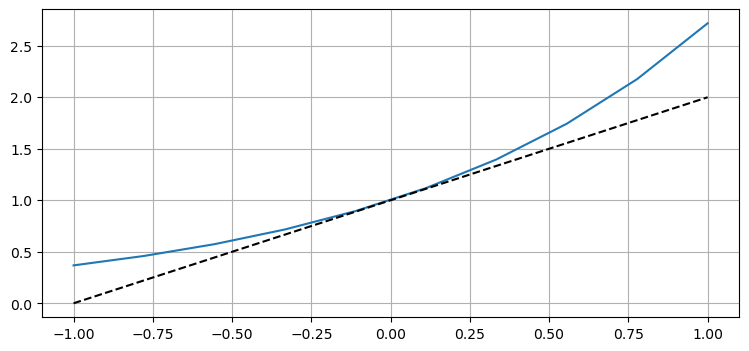

In [13]:
import matplotlib.pyplot as plt

t = np.linspace(-1, 1, 10)
plt.plot(t, np.exp(t))
t = np.linspace(-1, 1, 2)
plt.plot(t,t+1, ls='--', c='k');

你可以看到，当$t=0.1$时，斜率与曲线非常接近，但当$t=1$时，斜率与曲线相距甚远。但是让我们继续以1为步长。我们可以看到，在$t=1$时，$y$的估计值是2。现在我们可以计算$t=2$时的值，方法是将$t=1$时的曲线斜率加到初始估计值中。斜率是用$y'=y$来计算的，所以斜率是2。

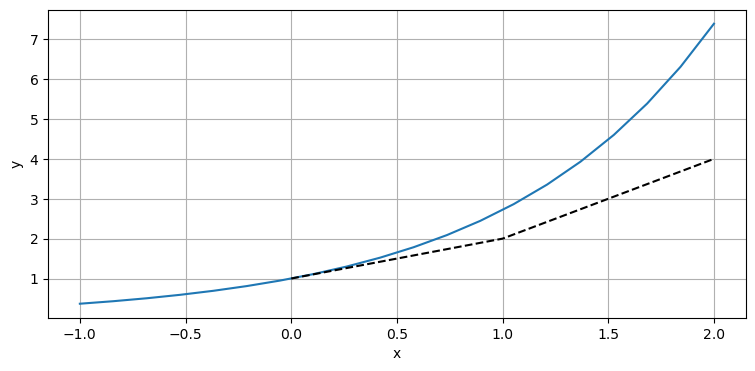

In [14]:
import kf_book.book_plots as book_plots

t = np.linspace(-1, 2, 20)
plt.plot(t, np.exp(t))
t = np.linspace(0, 1, 2)
plt.plot([1, 2, 4], ls='--', c='k')
book_plots.set_labels(x='x', y='y');

这里我们看到y的下一个估计是4。这些错误很快就会变得越来越大，而你可能对此无动于衷。但是1是一个很大的步长。让我们将这个算法放入代码中，并使用较小的步长来验证它是否有效。

In [15]:
def euler(t, tmax, y, dx, step=1.):
    ys = []
    while t < tmax:
        y = y + step*dx(t, y)
        ys.append(y)
        t +=step        
    return ys

In [16]:
def dx(t, y): return y

print(euler(0, 1, 1, dx, step=1.)[-1])
print(euler(0, 2, 1, dx, step=1.)[-1])

2.0
4.0


这是正确的。现在我们画一个小得多步长的结果。

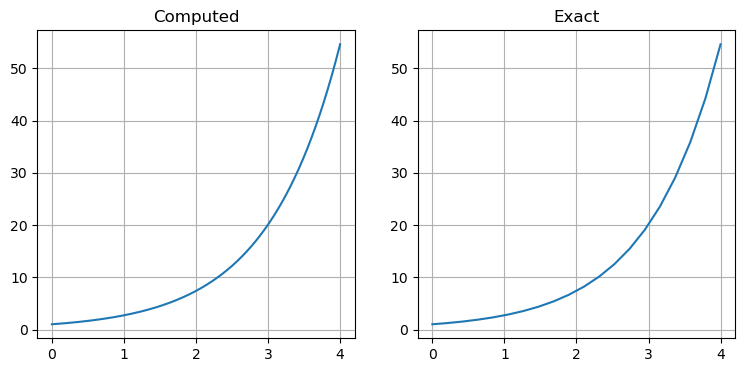

In [17]:
ys = euler(0, 4, 1, dx, step=0.00001)
plt.subplot(1,2,1)
plt.title('Computed')
plt.plot(np.linspace(0, 4, len(ys)),ys)
plt.subplot(1,2,2)
t = np.linspace(0, 4, 20)
plt.title('Exact')
plt.plot(t, np.exp(t));

In [18]:
print('exact answer=', np.exp(4))
print('euler answer=', ys[-1])
print('difference =', np.exp(4) - ys[-1])
print('iterations =', len(ys))

exact answer= 54.598150033144236
euler answer= 54.59705808834125
difference = 0.0010919448029866885
iterations = 400000


这里我们可以看到误差是相当小的，但是它需要非常多的迭代才能得到三位数的精度。在实践中，欧拉法对于大多数问题来说太慢了，我们使用更复杂的方法。

在我们继续之前，让我们正式推导欧拉方法，因为它是下一节使用的更高级的龙格库塔方法的基础。事实上，欧拉法是龙格库塔法的最简单形式。

这是$y$泰勒展开式的前三项。无限展开式会给出一个精确的答案，因此$O(h^4)$表示由于有限展开式而产生的误差。

$$y(t_0 + h) = y(t_0) + h y'(t_0) + \frac{1}{2!}h^2 y''(t_0) + \frac{1}{3!}h^3 y'''(t_0) +  O(h^4)$$

这里我们可以看到，欧拉方法使用了泰勒展开的前两项。每一项都比前一项小，因此我们可以保证估计值不会离正确值太远。

### 龙格库塔方法

龙格库塔是数值积分的主力。在文献中有大量的方法。在实践中，使用我在这里提出的龙格库塔算法可以解决你面临的大多数问题。它能很好地平衡速度、精度和稳定性，除非你有一个很好的理由选择不同的方法，否则它就是“go to”数值积分方法。

就让我们一探究竟吧。我们从微分方程开始

$$\ddot{y} = \frac{d}{dt}\dot{y}$$

我们可以把y的导数换成函数f，就像这样

$$\ddot{y} = \frac{d}{dt}f(y,t)$$

推导这些方程超出了本书的范围，但龙格库塔RK4方法是由这些方程定义的。

$$y(t+\Delta t) = y(t) + \frac{1}{6}(k_1 + 2k_2 + 2k_3 + k_4) + O(\Delta t^4)$$

$$\begin{aligned}
k_1 &= f(y,t)\Delta t \\
k_2 &= f(y+\frac{1}{2}k_1, t+\frac{1}{2}\Delta t)\Delta t \\
k_3 &= f(y+\frac{1}{2}k_2, t+\frac{1}{2}\Delta t)\Delta t \\
k_4 &= f(y+k_3, t+\Delta t)\Delta t
\end{aligned}
$$

对应代码如下:

In [19]:
def runge_kutta4(y, x, dx, f):
    """computes 4th order Runge-Kutta for dy/dx.
    y is the initial value for y
    x is the initial value for x
    dx is the difference in x (e.g. the time step)
    f is a callable function (y, x) that you supply 
    to compute dy/dx for the specified values.
    """
    
    k1 = dx * f(y, x)
    k2 = dx * f(y + 0.5*k1, x + 0.5*dx)
    k3 = dx * f(y + 0.5*k2, x + 0.5*dx)
    k4 = dx * f(y + k3, x + dx)
    
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6.

让我们用它来做一个简单的例子。让

$$\dot{y} = t\sqrt{y(t)}$$

初始值

$$\begin{aligned}t_0 &= 0\\y_0 &= y(t_0) = 1\end{aligned}$$

max error 0.00005


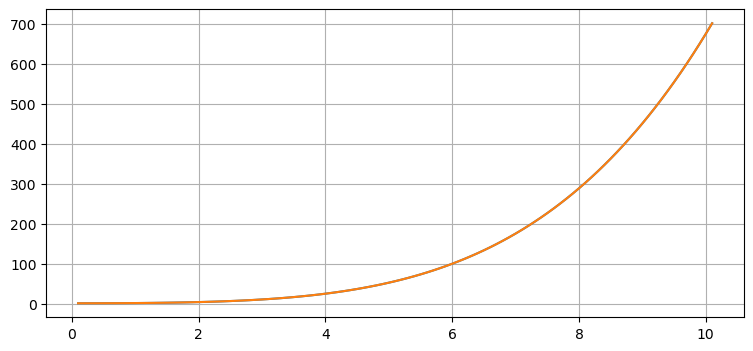

In [20]:
import math
import numpy as np
t = 0.
y = 1.
dt = .1

ys, ts = [], []

def func(y,t):
    return t*math.sqrt(y)

while t <= 10:
    y = runge_kutta4(y, t, dt, func)
    t += dt
    ys.append(y)
    ts.append(t)

exact = [(t**2 + 4)**2 / 16. for t in ts]
plt.plot(ts, ys)
plt.plot(ts, exact)

error = np.array(exact) - np.array(ys)
print(f"max error {max(error):.5f}")

## 贝叶斯过滤
 
从离散贝叶斯一章开始，我使用了贝叶斯公式进行过滤。假设我们正在跟踪一个物体。我们定义它在特定时间的“状态”为它的位置、速度等。例如，我们可以将$t$时刻的状态写成$\mathbf x_t = \begin{bmatrix}x_t &\dot x_t \end{bmatrix}^\mathsf T$。
 
当我们测量一个物体时，我们是在测量它的状态或它的一部分。传感器是有噪声的，所以测量被噪声破坏了。很明显，测量是由状态决定的。也就是说，状态的变化可能会改变测量值，但测量值的变化不会改变状态。
  
在过滤中，我们的目标是计算一组状态$\mathbf x_{0:t}$从时间0到时间$t$的最优估计。如果我们知道$\mathbf x_{0:t}$，那么计算一组对应于这些状态的测量值$\mathbf z_{0:t}$就很简单了。然而，我们收到一组测量值$\mathbf z_{0:t}$，并希望计算相应的状态$\mathbf x_{0:t}$。这被称为“统计反演”，因为我们试图从输出中计算输入。
 
反演是一个困难的问题，因为通常没有唯一的解。对于给定的状态集$\mathbf x_{0:t}$，只有一组可能的测量值(加上噪声)，但是对于给定的一组测量值，有许多不同的状态集可能导致这些测量值。

回顾贝叶斯定理:

$$P(x \mid z) = \frac{P(z \mid x)P(x)}{P(z)}$$
 
其中$P(z \mid x)$是度量$z$的*可能性*，$P(x)$是基于我们的过程模型的*先验*，而$P(z)$是一个标准化常数。$P(x \mid z)$是后验的，或包含测量后的分布$z$，也称为*证据*。

当它从$P(z \mid x)$到$P(x \mid z)$时，这是一个*统计倒置*。我们的过滤问题的解决方案可以表示为:

$$P(\mathbf x_{0:t} \mid \mathbf z_{0:t}) = \frac{P(\mathbf z_{0:t} \mid \mathbf x_{0:t})P(\mathbf x_{0:t})}{P(\mathbf z_{0:t})}$$
 
这一切都很好，直到下一个测量$\mathbf z_{t+1}$到来，此时我们需要重新计算范围$0:t+1$的整个表达式。
 
在实践中，这是棘手的，因为我们试图计算状态在整个时间步长的后验分布$P(\mathbf x_{0:t} \mid \mathbf z_{0:t})$。但我们真的在乎第三步时的概率分布吗?不是很经常。所以我们放宽要求，只计算当前时间步长的分布。

第一个简化是我们将我们的过程(例如，一个运动物体的运动模型)描述为*马尔可夫链*。也就是说，我们说当前状态只依赖于前一个状态和一个转移概率$P(\mathbf x_k \mid \mathbf x_{k-1})$，也就是从上一个状态到当前状态的概率。我们写:

$$\mathbf x_k \sim P(\mathbf x_k \mid \mathbf x_{k-1})$$
 
在实践中，这是非常合理的，因为许多事物都具有*马尔可夫性质*。如果你在停车场开车，你下一秒的位置是否取决于你是停在州际公路上还是一分钟前在土路上爬行?不。你下一秒的位置完全取决于你当前的位置、速度和控制输入，而不是一分钟前发生的事情。因此，汽车具有马尔可夫性质，我们可以在不损失精度或一般性的情况下进行这种简化。
 
我们做的下一个简化是定义*度量模型*取决于当前状态$\mathbf x_k$，带有给定当前状态的度量的条件概率:$P(\mathbf z_t \mid \mathbf x_x)$。我们写:

$$\mathbf z_k \sim P(\mathbf z_t \mid \mathbf x_x)$$
 
现在我们有一个递归，所以我们需要一个初始条件来终止它。因此我们说初始分布是状态$\mathbf x_0$的概率:

$$\mathbf x_0 \sim P(\mathbf x_0)$$
 
这些项被代入贝叶斯方程。如果我们有状态$\mathbf x_0$和第一次测量，我们可以估计$P(\mathbf x_1 | \mathbf z_1)$。运动模型创建之前的$P(\mathbf x_2 \mid \mathbf x_1)$。我们把这个反馈到贝叶斯定理中来计算$P(\mathbf x_2 | \mathbf z_2)$。我们继续这个预测-校正算法，仅根据$t-1$的状态和分布以及$t$的度量，递归地计算$t$时刻的状态和分布。
  
这种计算的数学细节因问题而异。**离散贝叶斯**和**单变量卡尔曼滤波**章节给出了两个不同的公式，你应该已经能够通过它们进行推理。单变量卡尔曼滤波假设对于标量状态，噪声和过程都是线性模型，受到零均值、不相关高斯噪声的影响。
 
多元卡尔曼滤波器做了同样的假设，但对于状态和测量是矢量，而不是标量。卡尔曼博士能够证明，如果这些假设成立，那么卡尔曼滤波器在最小二乘意义上是*最优的*。通俗地说，这意味着没有办法从噪声测量中获得更多的信息。在书的其余部分，我将介绍放松线性和高斯噪声约束的过滤器。
 
在我继续之前，再多说几句关于统计倒置的内容。正如Calvetti和Somersalo在《贝叶斯科学计算导论》中所写的那样，“我们采用贝叶斯的观点:*随机性仅仅意味着信息的缺乏*。”我们的状态参数化了我们原则上可以测量或计算的物理现象:速度、空气阻力等等。我们缺乏足够的信息来计算或测量它们的价值，所以我们选择将它们视为随机变量。严格地说，它们不是随机的，因此这是一个主观的立场。
 
他们用了整整一章的篇幅来讨论这个话题。我可以抽出一段来。贝叶斯滤波器之所以成为可能，是因为我们将统计特性归因于未知参数。在卡尔曼滤波器的情况下，我们有闭型解来找到一个最优估计。其他过滤器，如离散贝叶斯过滤器或粒子过滤器，我们将在后面的章节中介绍，以一种更特别的、非最优的方式对概率建模。我们技术的强大之处就在于将信息的缺乏视为一个随机变量，将该随机变量描述为一个概率分布，然后使用贝叶斯定理来解决统计推断问题。

## 将卡尔曼滤波器转换为g-h滤波器

我已经说过卡尔曼滤波器是g-h滤波器的一种形式。只是需要一些代数运算来证明它。在一维情况下更简单，我就这么做。回忆

$$
\mu_{x}=\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}
$$

我将使它对我们的眼睛更加友好，就像:

$$
\mu_{x}=\frac{ya + xb} {a+b}
$$

我们可以很容易地把它化成g-h形式通过下面的代数运算

$$
\begin{aligned}
\mu_{x}&=(x-x) + \frac{ya + xb} {a+b} \\
\mu_{x}&=x-\frac{a+b}{a+b}x  + \frac{ya + xb} {a+b} \\ 
\mu_{x}&=x +\frac{-x(a+b) + xb+ya}{a+b} \\
\mu_{x}&=x+ \frac{-xa+ya}{a+b}  \\
\mu_{x}&=x+ \frac{a}{a+b}(y-x)\\
\end{aligned}
$$

我们差不多做完了，但是回忆一下估计的方差是

$$\begin{aligned}
\sigma_{x}^2 &= \frac{1}{\frac{1}{\sigma_1^2} +  \frac{1}{\sigma_2^2}} \\
&= \frac{1}{\frac{1}{a} +  \frac{1}{b}}
\end{aligned}$$

通过观察，我们可以把这一项纳入上面的方程

$$ 
\begin{aligned}
\frac{a}{a+b} &= \frac{a/a}{(a+b)/a} = \frac{1}{(a+b)/a}  \\
 &= \frac{1}{1 + \frac{b}{a}} = \frac{1}{\frac{b}{b} + \frac{b}{a}}  \\
 &= \frac{1}{b}\frac{1}{\frac{1}{b} + \frac{1}{a}} \\
 &= \frac{\sigma^2_{x'}}{b}
 \end{aligned}
$$

我们可以把这些联系起来

$$
\begin{aligned}
\mu_{x}&=x+ \frac{a}{a+b}(y-x) \\
&= x + \frac{\sigma^2_{x'}}{b}(y-x) \\
&= x + g_n(y-x)
\end{aligned}
$$

其中

$$g_n = \frac{\sigma^2_{x}}{\sigma^2_{y}}$$
 
最终结果是将两个测量值的残差乘以一个常数，并加上我们之前的值，即g-h滤波器的$g$方程。$g$是新估计的方差除以测量的方差。当然，在这种情况下$g$不是一个常数，因为它随着方差的变化而随每个时间步长而变化。我们也可以用同样的方法推导$h$的公式。这不是一个特别有启发性的推导，我将跳过它。最终结果是

$$h_n = \frac{COV (x,\dot x)}{\sigma^2_{y}}$$
 
要点是$g$和$h$完全由时间$n$的测量和预测的方差和协方差指定。换句话说，我们通过一个由这两个输入的质量所决定的比例因子在测量和预测之间选择一个点。

## References

 * [1] C.B. Molwer and C.F. Van Loan "Nineteen Dubious Ways to Compute the Exponential of a Matrix, Twenty-Five Years Later,", *SIAM Review 45, 3-49*. 2003.


 * [2] C.F. van Loan, "Computing Integrals Involving the Matrix Exponential," IEEE *Transactions Automatic Control*, June 1978.
 
 
 * [3] Calvetti, D and Somersalo E, "Introduction to Bayesian Scientific Computing: Ten Lectures on Subjective Computing,", *Springer*, 2007.
 
 * [4] Brown, R. G. and Hwang, P. Y.C., "Introduction to Random Signals and Applied Kalman Filtering", *Wiley and Sons*, Fourth Edition, p.143-147, 2012. 
 